In [26]:
## Use SVM and SGD to attempt to model and predict the class of an internet connection request.
## Import Necessary Libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

In [2]:
#load data
df = pd.read_csv('log2.csv')
df = df.round(5)
df.info()
df.describe().apply(lambda s: s.apply('{0:.5f}'.format)) # will get summary of continuous or the nominals non-scientific

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000
mean,49391.96934,10577.38581,19282.97276,2671.04993,97123.95009,22385.79691,74738.15318,102.86603,65.83358,41.39953,61.46650
std,15255.71254,18466.02704,21970.68967,9739.16228,5618438.90905,3828138.64979,2463207.71188,5133.00235,302.46176,3218.87129,2223.33227
min,0.00000,0.00000,0.00000,0.00000,60.00000,60.00000,0.00000,1.00000,0.00000,1.00000,0.00000
25%,49183.00000,80.00000,0.00000,0.00000,66.00000,66.00000,0.00000,1.00000,0.00000,1.00000,0.00000
50%,53776.50000,445.00000,8820.50000,53.00000,168.00000,90.00000,79.00000,2.00000,15.00000,1.00000,1.00000
75%,58638.00000,15000.00000,38366.25000,443.00000,752.25000,210.00000,449.00000,6.00000,30.00000,3.00000,2.00000
max,65534.00000,65535.00000,65535.00000,65535.00000,1269359015.00000,948477220.00000,320881795.00000,1036116.00000,10824.00000,747520.00000,327208.00000


In [3]:
## Visualize missingness 
#Check out the data, start to make some decisions on columns and missing data

#Compute percentages of each columns missing data
percent_missing = df.isnull().sum() * 100 / len(df)
#Put percents into df 
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
#Sort it and show the results
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,column_name,percent_missing
Source Port,Source Port,0.0
Destination Port,Destination Port,0.0
NAT Source Port,NAT Source Port,0.0
NAT Destination Port,NAT Destination Port,0.0
Action,Action,0.0
Bytes,Bytes,0.0
Bytes Sent,Bytes Sent,0.0
Bytes Received,Bytes Received,0.0
Packets,Packets,0.0
Elapsed Time (sec),Elapsed Time (sec),0.0


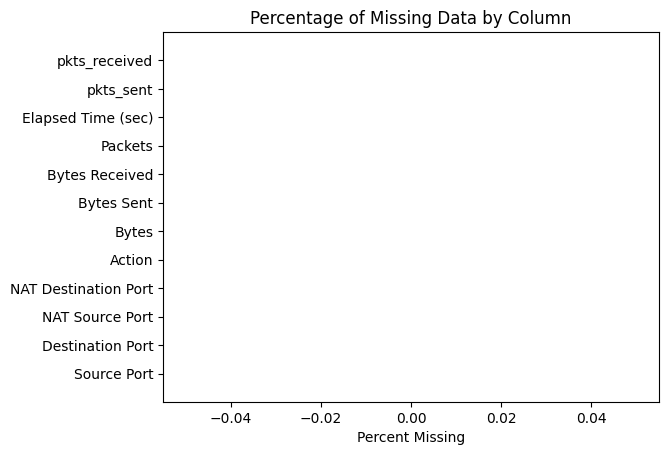

In [4]:
# Create bar chart of missing data percentages
plt.barh(missing_value_df['column_name'], missing_value_df['percent_missing'])

# Add labels and title
plt.xlabel('Percent Missing')
plt.title('Percentage of Missing Data by Column')

# Display the graph
plt.show()

In [5]:
## no missing data. Good

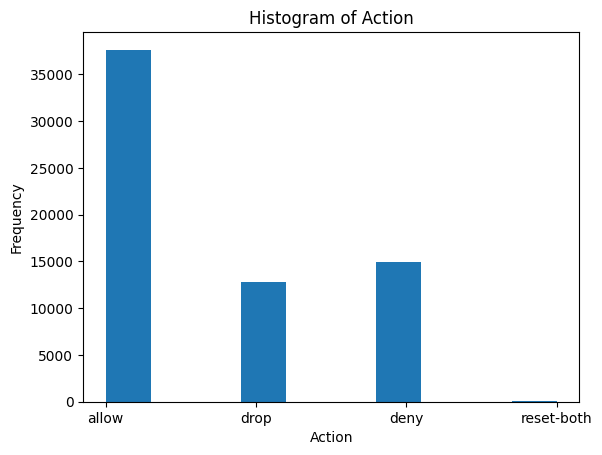

In [6]:
## the response variable is action graph to look at our actions
plt.hist(df['Action'])
plt.xlabel('Action')
plt.ylabel('Frequency')
plt.title('Histogram of Action')
plt.show()

In [7]:
df['Action'].value_counts(normalize=False)


allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64

In [8]:
print(df)

       Source Port  Destination Port  NAT Source Port  NAT Destination Port  \
0            57222                53            54587                    53   
1            56258              3389            56258                  3389   
2             6881             50321            43265                 50321   
3            50553              3389            50553                  3389   
4            50002               443            45848                   443   
...            ...               ...              ...                   ...   
65527        63691                80            13237                    80   
65528        50964                80            13485                    80   
65529        54871               445                0                     0   
65530        54870               445                0                     0   
65531        54867               445                0                     0   

      Action    Bytes  Bytes Sent  Bytes Received  

In [9]:
df['Action'] = df['Action'].astype('category')
df['Source Port'] = df['Source Port'].astype('category')
df['Destination Port'] = df['Destination Port'].astype('category')
df['NAT Source Port'] = df['NAT Source Port'].astype('category')
df['NAT Destination Port'] = df['Destination Port'].astype('category')
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000
mean,97123.95009,22385.79691,74738.15318,102.86603,65.83358,41.39953,61.46650
std,5618438.90905,3828138.64979,2463207.71188,5133.00235,302.46176,3218.87129,2223.33227
min,60.00000,60.00000,0.00000,1.00000,0.00000,1.00000,0.00000
25%,66.00000,66.00000,0.00000,1.00000,0.00000,1.00000,0.00000
50%,168.00000,90.00000,79.00000,2.00000,15.00000,1.00000,1.00000
75%,752.25000,210.00000,449.00000,6.00000,30.00000,3.00000,2.00000
max,1269359015.00000,948477220.00000,320881795.00000,1036116.00000,10824.00000,747520.00000,327208.00000


In [10]:
#We want to change the Action column here to numerical data for algorithms. 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#Using fit.transform function to fit label
#encoder and return encoded labels
label = le.fit_transform(df['Action'])

#Print unique values
print(label)

#Remove the column "Action" from the original dataframe
#df_scaled.drop('Action', axis = 1, inplace=True)

#Appending the array to the dataframe
df['Label_Action'] = df['Action']
df['Action'] = label

#Print Dataframe 0 = Allow, 1 = Deny, 2 =  Drop , 3 = Reset-Both
df['Action'].unique()

[0 0 0 ... 2 2 2]


array([0, 2, 1, 3])

In [11]:
# Select columns to scale
# do not scale source and destination ports... domain knowledge
cols_to_scale = ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']

# Scale selected columns
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[cols_to_scale] = scaler.fit_transform(df_scaled[cols_to_scale])

# Print the scaled dataframe
print(df_scaled.head())


  Source Port Destination Port NAT Source Port NAT Destination Port  Action  \
0       57222               53           54587                   53       0   
1       56258             3389           56258                 3389       0   
2        6881            50321           43265                50321       0   
3       50553             3389           50553                 3389       0   
4       50002              443           45848                  443       0   

      Bytes  Bytes Sent  Bytes Received   Packets  Elapsed Time (sec)  \
0 -0.017255   -0.005823       -0.030308 -0.019651           -0.118474   
1 -0.016438   -0.005430       -0.029056 -0.016339           -0.161455   
2 -0.017244   -0.005817       -0.030293 -0.019651            3.746507   
3 -0.016695   -0.005472       -0.029575 -0.017118           -0.161455   
4 -0.012773   -0.004077       -0.022799 -0.014001           -0.164761   

   pkts_sent  pkts_received Label_Action  
0  -0.012551      -0.027197        allow  


In [12]:
df_scaled

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Label_Action
0,57222,53,54587,53,0,-0.017255,-0.005823,-0.030308,-0.019651,-0.118474,-0.012551,-0.027197,allow
1,56258,3389,56258,3389,0,-0.016438,-0.005430,-0.029056,-0.016339,-0.161455,-0.009755,-0.023598,allow
2,6881,50321,43265,50321,0,-0.017244,-0.005817,-0.030293,-0.019651,3.746507,-0.012551,-0.027197,allow
3,50553,3389,50553,3389,0,-0.016695,-0.005472,-0.029575,-0.017118,-0.161455,-0.010376,-0.024498,allow
4,50002,443,45848,443,0,-0.012773,-0.004077,-0.022799,-0.014001,-0.164761,-0.008823,-0.019550,allow
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,0,-0.017231,-0.005798,-0.030293,-0.018871,-0.168067,-0.011619,-0.026747,allow
65528,50964,80,13485,80,0,0.815823,0.011736,1.842607,0.890740,0.036919,0.293149,1.632037,allow
65529,54871,445,0,445,2,-0.017274,-0.005829,-0.030342,-0.019845,-0.217661,-0.012551,-0.027646,drop
65530,54870,445,0,445,2,-0.017274,-0.005829,-0.030342,-0.019845,-0.217661,-0.012551,-0.027646,drop


In [13]:
df_scaled.dtypes

Source Port             category
Destination Port        category
NAT Source Port         category
NAT Destination Port    category
Action                     int32
Bytes                    float64
Bytes Sent               float64
Bytes Received           float64
Packets                  float64
Elapsed Time (sec)       float64
pkts_sent                float64
pkts_received            float64
Label_Action            category
dtype: object

In [15]:
df_scaled.memory_usage()

Index                       128
Source Port              841280
Destination Port         289384
NAT Source Port         1421088
NAT Destination Port     289384
Action                   262128
Bytes                    524256
Bytes Sent               524256
Bytes Received           524256
Packets                  524256
Elapsed Time (sec)       524256
pkts_sent                524256
pkts_received            524256
Label_Action              65736
dtype: int64

In [16]:
# Split the data into train and test sets
X = df_scaled.drop(['Action','Label_Action'], axis=1)
y = df_scaled['Action']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [76]:
X

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,-0.017255,-0.005823,-0.030308,-0.019651,-0.118474,-0.012551,-0.027197
1,56258,3389,56258,3389,-0.016438,-0.005430,-0.029056,-0.016339,-0.161455,-0.009755,-0.023598
2,6881,50321,43265,50321,-0.017244,-0.005817,-0.030293,-0.019651,3.746507,-0.012551,-0.027197
3,50553,3389,50553,3389,-0.016695,-0.005472,-0.029575,-0.017118,-0.161455,-0.010376,-0.024498
4,50002,443,45848,443,-0.012773,-0.004077,-0.022799,-0.014001,-0.164761,-0.008823,-0.019550
...,...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,-0.017231,-0.005798,-0.030293,-0.018871,-0.168067,-0.011619,-0.026747
65528,50964,80,13485,80,0.815823,0.011736,1.842607,0.890740,0.036919,0.293149,1.632037
65529,54871,445,0,445,-0.017274,-0.005829,-0.030342,-0.019845,-0.217661,-0.012551,-0.027646
65530,54870,445,0,445,-0.017274,-0.005829,-0.030342,-0.019845,-0.217661,-0.012551,-0.027646


In [77]:
y

0        0
1        0
2        0
3        0
4        0
        ..
65527    0
65528    0
65529    2
65530    2
65531    2
Name: Action, Length: 65532, dtype: int32

In [19]:
#Create Cross Validation Procedure
cv = StratifiedKFold(n_splits=10, random_state=1234, shuffle=True)

In [20]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_recall_curve,  accuracy_score, confusion_matrix, average_precision_score

SVM = LinearSVC()

# define parameters
C_SVM = [0.1, 1, 5, 10]
class_weight_SVM = ['balanced', None]
random_state_SVM = [1234]

# define grid search

param_grid_SVM = dict(C=C_SVM, class_weight=class_weight_SVM,
                      random_state=random_state_SVM)

grid_search_SVM = GridSearchCV(estimator=SVM, param_grid=param_grid_SVM, n_jobs=10, cv=cv, 
                               scoring='accuracy',error_score=0, verbose=1)

In [21]:
%%time
grid_result_SVM = grid_search_SVM.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result_SVM.best_score_, grid_result_SVM.best_params_))
means = grid_result_SVM.cv_results_['mean_test_score']
stds = grid_result_SVM.cv_results_['std_test_score']
params = grid_result_SVM.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best: 0.965188 using {'C': 0.1, 'class_weight': 'balanced', 'random_state': 1234}
0.965188 (0.022840) with: {'C': 0.1, 'class_weight': 'balanced', 'random_state': 1234}
0.899072 (0.082320) with: {'C': 0.1, 'class_weight': None, 'random_state': 1234}
0.910953 (0.122711) with: {'C': 1, 'class_weight': 'balanced', 'random_state': 1234}
0.912853 (0.117777) with: {'C': 1, 'class_weight': None, 'random_state': 1234}
0.889053 (0.118075) with: {'C': 5, 'class_weight': 'balanced', 'random_state': 1234}
0.955652 (0.025231) with: {'C': 5, 'class_weight': None, 'random_state': 1234}
0.932128 (0.074216) with: {'C': 10, 'class_weight': 'balanced', 'random_state': 1234}
0.870635 (0.107963) with: {'C': 10, 'class_weight': None, 'random_state': 1234}
CPU times: total: 438 ms
Wall time: 1min 52s


C:\ProgramData\Anaconda3\envs\QTW\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [22]:
# The GridSearch algorithm determined the following optimal parameters
best_Estimator_SVM =grid_result_SVM.best_estimator_
best_Estimator_SVM

LinearSVC(C=0.1, class_weight='balanced', random_state=1234)

In [70]:
# Model Metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score , recall_score

f1_scorer = make_scorer(f1_score, average='weighted')
accuracy_scorer = make_scorer(accuracy_score, average='weighted')
precision_scorer = make_scorer(average_precision_score , average='weighted')
recall_scorer = make_scorer(recall_score, average='weighted')

def displayModel_metrics(best_model, grid_model, features, target, cv):
    metrics = cross_validate(best_model, features, y=target, cv=cv, 
                             scoring=['accuracy','precision_macro','recall_macro', 'f1_macro'], return_train_score=True) 
    
    y_predict = cross_val_predict(best_model, features, target, cv=cv)

    print('\nBest Accuracy with Grid Search            : {:.3f}'.format(grid_model.best_score_))
    print('\nTraining data Metrics')
    print('\n     The average accuraccy : {:.3f}'.format(metrics['train_accuracy'].mean()))
    print('     The average precision : {:.3f}'.format(metrics['train_precision_macro'].mean()))
    print('     The average recall    : {:.3f}'.format(metrics['train_recall_macro'].mean()))
    print('     The average f1 score    : {:.3f}'.format(metrics['train_f1_macro'].mean()))

    print('\nTest data Metrics')
    print('\n     The average accuracy  : {:.3f}'.format(metrics['test_accuracy'].mean()))
    print('     The average precision : {:.3f}'.format(metrics['test_precision_macro'].mean()))
    print('     The average  recall   : {:.3f}'.format(metrics['test_recall_macro'].mean()))
    print('     The average f1 score    : {:.3f}'.format(metrics['test_f1_macro'].mean()))
    
    matrix = classification_report(target, y_predict, labels=[1,0])
    print('\nClassification report\n')
    print(matrix)

In [71]:
# Display model metrics
displayModel_metrics(best_Estimator_SVM, grid_result_SVM, X_train, y_train, cv)

C:\ProgramData\Anaconda3\envs\QTW\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\QTW\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\QTW\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\QTW\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\ProgramData\A


Best Accuracy with Grid Search            : 0.965

Training data Metrics

     The average accuraccy : 0.964
     The average precision : 0.718
     The average recall    : 0.728
     The average f1 score    : 0.722

Test data Metrics

     The average accuracy  : 0.965
     The average precision : 0.718
     The average  recall   : 0.728
     The average f1 score    : 0.722

Classification report

              precision    recall  f1-score   support

           1       0.95      0.95      0.95     11993
           0       1.00      0.96      0.98     30095

   micro avg       0.98      0.96      0.97     42088
   macro avg       0.97      0.96      0.96     42088
weighted avg       0.98      0.96      0.97     42088



C:\ProgramData\Anaconda3\envs\QTW\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


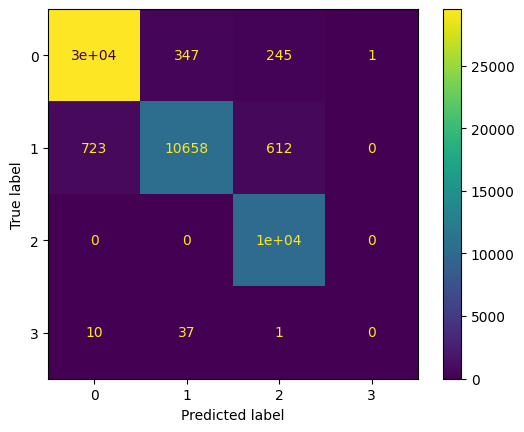

In [72]:
# training data confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

predictions = grid_result_SVM.predict(X_train)
cm = confusion_matrix(y_train, predictions, labels=grid_result_SVM.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid_result_SVM.classes_)
disp.plot()
plt.show()

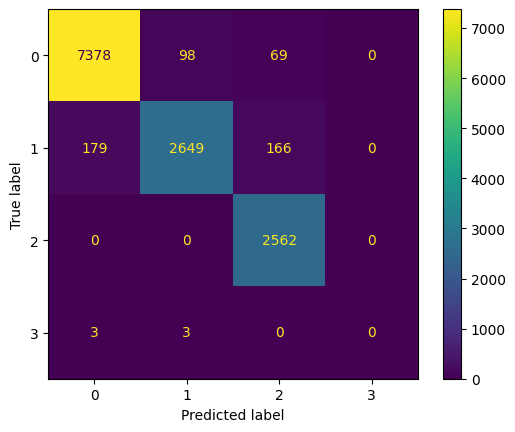

In [73]:
# test data confusion matrix
predictions = grid_result_SVM.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=grid_result_SVM.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid_result_SVM.classes_)
disp.plot()
plt.show()

Text(0.5, 0, 'Permutation Importance')

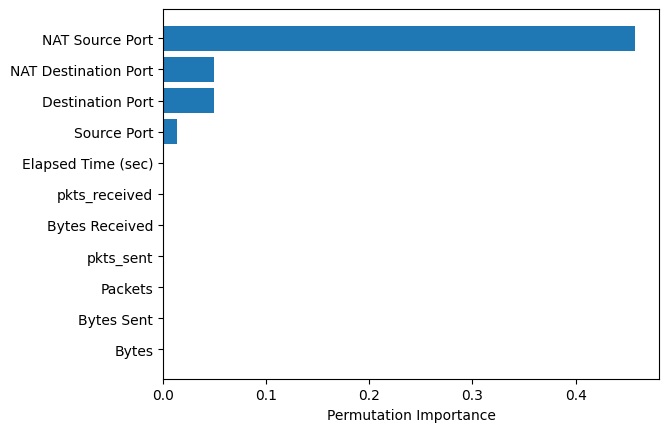

In [78]:
# https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn
from sklearn.inspection import permutation_importance
import numpy as np
perm_importance = permutation_importance(grid_search_SVM.best_estimator_, X_train, y_train)

feature_names = X.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [79]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

In [80]:

# Simple Linear SVM Model with default parameters
simple_model = LinearSVC()
print(cross_val_score(simple_model,X_train,y_train, cv = 5, scoring = 'accuracy').mean())

C:\ProgramData\Anaconda3\envs\QTW\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\QTW\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\QTW\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\QTW\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.90689556509299


C:\ProgramData\Anaconda3\envs\QTW\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [81]:
%%time
#Now We will use a randomized search through the parameters to make a better score
params = {'loss': ['hinge','squared_hinge'], 
         'tol': [1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1],
         'C':  [1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1]}

clf = RandomizedSearchCV(simple_model, params, scoring = 'accuracy', n_jobs = -1, cv = 5)
clf.fit(X_train,y_train)

print("Best Parameters found on the development set:")
print()
print(clf.best_params_)
print()
print("Grid Scores on the development sets:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean,std * 2, params))
    print()
    print('Detailed classification report:')
    print()
    print('The model is trained on full development set.')
    print('The scores are computed on the full evaluation set')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true,y_pred, zero_division = 1))
    print()

Best Parameters found on the development set:

{'tol': 0.1, 'loss': 'hinge', 'C': 1e-09}

Grid Scores on the development sets:

0.966 (+/-0.001) for {'tol': 1e-10, 'loss': 'squared_hinge', 'C': 1e-09}

Detailed classification report:

The model is trained on full development set.
The scores are computed on the full evaluation set

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      7545
           1       0.97      0.93      0.95      2994
           2       0.89      1.00      0.94      2562
           3       1.00      0.00      0.00         6

    accuracy                           0.97     13107
   macro avg       0.97      0.73      0.72     13107
weighted avg       0.97      0.97      0.97     13107


0.823 (+/-0.235) for {'tol': 0.1, 'loss': 'hinge', 'C': 0.001}

Detailed classification report:

The model is trained on full development set.
The scores are computed on the full evaluation set

              precision    recall  f

In [84]:
#Best parameter for LinearSVC, #Fill in the best parameters here
best_model = LinearSVC(tol = .1, loss = 'hinge', C =  1e-09)
print(cross_val_score(best_model,X_train,y_train, cv = 5, scoring = 'accuracy').mean())

0.9703576537911301


In [85]:
# Stochastic Gradient Descent

In [86]:
#Using the stochastic gradient descent using the default parameters
%time
simple_SGD = SGDClassifier(early_stopping = True, n_iter_no_change = 3)
print(cross_val_score(simple_SGD,X_train,y_train, scoring = 'accuracy', n_jobs = -1, cv = 5).mean())

CPU times: total: 0 ns
Wall time: 0 ns
0.9668478779208393


In [87]:
%time
params = {'loss': ['hinge','squared_hinge', 'log','squared_error'],
          'alpha': [1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1],
         'tol': [1e-8,1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1]}

clf = RandomizedSearchCV(simple_SGD, params, scoring = 'accuracy', n_jobs = -1, cv = 5)
clf.fit(X_train,y_train)

print("Best Parameters found on the development set:")
print()
print(clf.best_params_)
print()
print("Grid Scores on the development sets:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean,std * 2, params))
    print()
    print('Detailed classification report:')
    print()
    print('The model is trained on full development set.')
    print('The scores are computed on the full evaluation set')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true,y_pred, zero_division = 1))
    print()

CPU times: total: 0 ns
Wall time: 0 ns
Best Parameters found on the development set:

{'tol': 1, 'loss': 'squared_hinge', 'alpha': 0.01}

Grid Scores on the development sets:

0.913 (+/-0.149) for {'tol': 1e-05, 'loss': 'log', 'alpha': 1e-08}

Detailed classification report:

The model is trained on full development set.
The scores are computed on the full evaluation set

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      7545
           1       0.97      0.96      0.96      2994
           2       0.93      1.00      0.96      2562
           3       1.00      0.00      0.00         6

    accuracy                           0.98     13107
   macro avg       0.97      0.73      0.73     13107
weighted avg       0.98      0.98      0.98     13107


0.929 (+/-0.140) for {'tol': 0.0001, 'loss': 'hinge', 'alpha': 1}

Detailed classification report:

The model is trained on full development set.
The scores are computed on the full evaluat

In [91]:
#Best parameters classifier, #Fill in the best parameters here
best_SGD = SGDClassifier(tol = 1, loss = 'squared_hinge', alpha = 0.01)
print(cross_val_score(best_SGD,X_train,y_train, scoring = 'accuracy', n_jobs = -1, cv = 5).mean())

0.922136385312351


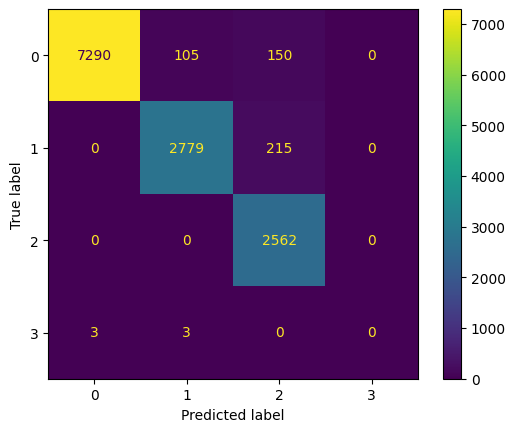

In [92]:
#ANALYSIS for LinearSVC
#Compute a Classification Matrix Here Visually 
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay

#Best parameter for LinearSVC, #Fill in the best parameters here
best_model = LinearSVC(tol = .1, loss = 'hinge', C =  1e-09)
p = cross_val_predict(best_model,X_test,y_test, cv = 5)
ConfusionMatrixDisplay.from_predictions(y_test,p)

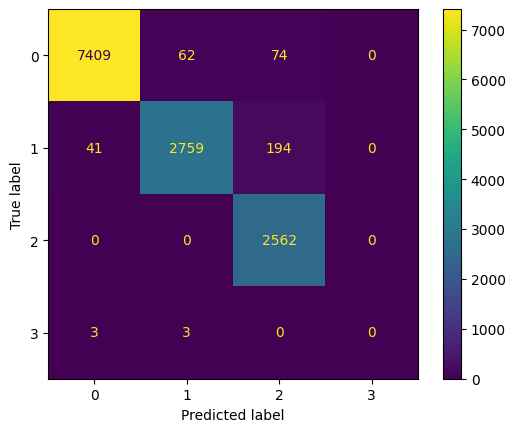

In [93]:
#ANALYSIS for SGDClassifier
#Compute a classification Matrix Here Visually
best_SGD = SGDClassifier(tol = 1, loss = 'squared_hinge', alpha = 0.01)
p1 = cross_val_predict(best_SGD,X_test,y_test, cv = 5)
ConfusionMatrixDisplay.from_predictions(y_test,p1)